# View and export review of long recordings from single wearer
Review and export excerpt data and images of long single participant recordings using the equivital vest and downloaded with the Qiosk interface. 

In [146]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [147]:
%load_ext autoreload
%autoreload 1
%aimport qex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%reload_ext autoreload

## Find csvs and do a quick review and export

In [171]:
# location of the files when exported by QIOSK
path = '../SoloConcerting/SoloRecordings'
seperater = '/'
df_datafiles = qex.qiosk_recordings(path,'Present',seperater)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,Test1,3420415,230120,7,DATA-Test1-3420415-23012007.CSV,csv,858075,2023-01-20 22:00:08+00:00,2023-01-21 13:31:13+00:00,...,[Test1],3420415.0,Test1,NaN,61,99,0,0,MovingSlowly,Side
1,DATA,Pilot_1,3420755,230201,0,DATA-Pilot_1-3420755-23020100.CSV,csv,62494,2023-02-01 17:14:56+00:00,2023-02-01 20:30:11+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,78,98,0,0,Stationary,Upright
2,DATA,Pilot_1,3420755,230201,0,DATA-Pilot_1-3420755-23020100-trimmed.csv,csv,33702,2023-02-01 18:03:41+00:00,2023-02-01 19:52:26+00:00,...,[Pilot_1],3420755.0,Pilot_1,NaN,78,98,0,0,Stationary,Upright


In [150]:
dataLoc = df_datafiles.loc[1,'FullLoc']

../SoloConcerting/SoloRecordings/CSV/ECG-Pilot_1-3420755-23020100.csv
../SoloConcerting/SoloRecordings/CSV/RESPACC-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/DATA-Test1-3420415-23012007.CSV
../SoloConcerting/SoloRecordings/CSV/ECG-Test1-3420415-23012007.csv
../SoloConcerting/SoloRecordings/CSV/RESPACC-Test1-3420415-23012007.CSV
../SoloConcerting/SoloRecordings/CSV/RR-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/DATA-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/RR-Test1-3420415-23012007.CSV
../SoloConcerting/SoloRecordings/CSV/ECG-Pilot_1-3420755-23020100.csv
Index(['DateTime', 'Lead 1', 'Lead 2'], dtype='object')


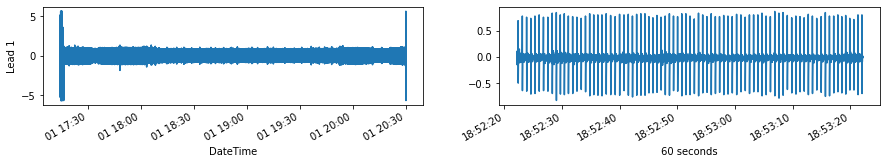

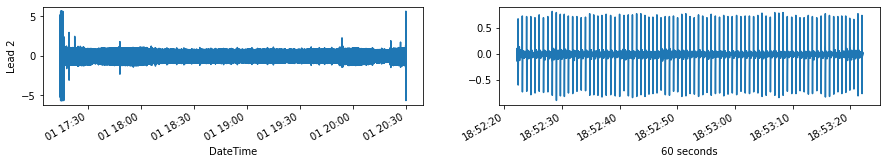

../SoloConcerting/SoloRecordings/CSV/RESPACC-Pilot_1-3420755-23020100.CSV
Index(['DateTime', 'Breathing', 'Vert Accelerometer', 'Lat Accelerometer',
       'Long Accelerometer'],
      dtype='object')


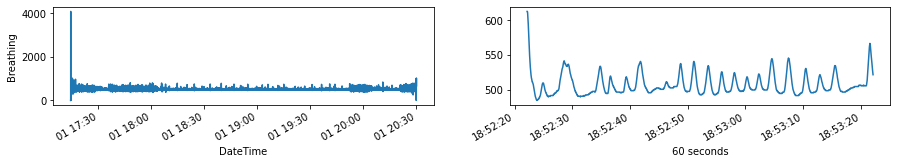

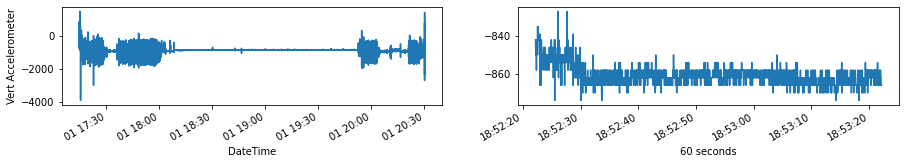

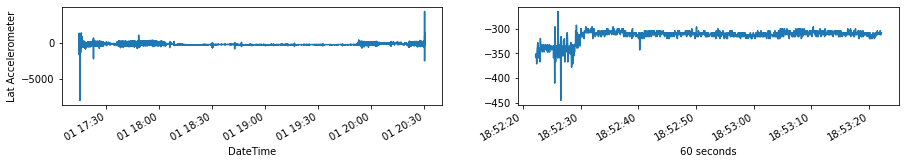

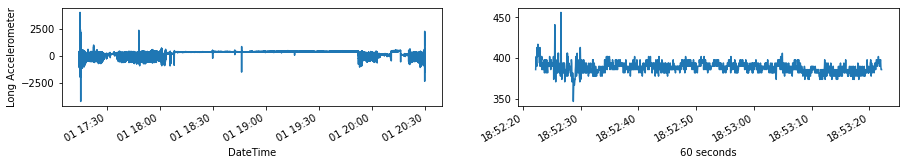

../SoloConcerting/SoloRecordings/CSV/RR-Pilot_1-3420755-23020100.CSV
Index(['DateTime', 'Interbeat Interval (MS)'], dtype='object')


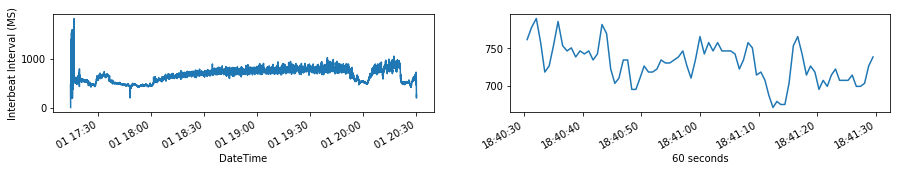

../SoloConcerting/SoloRecordings/CSV/DATA-Pilot_1-3420755-23020100.CSV
Index(['DateTime', 'SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)',
       'HRC(%)', 'BELT OFF', 'LEAD OFF', 'MOTION', 'BODY POSITION',
       'BATTERY(mV)'],
      dtype='object')


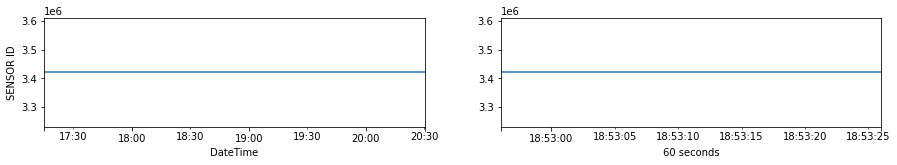

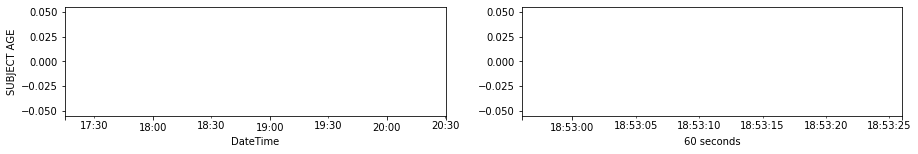

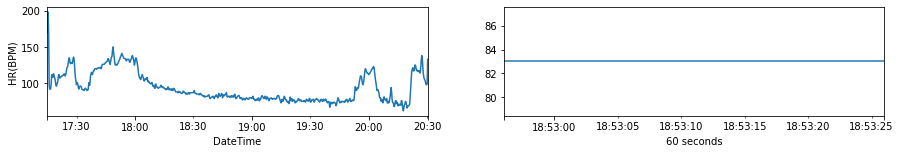

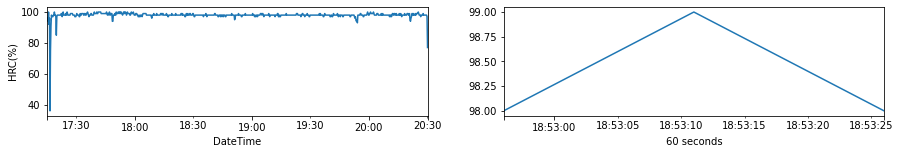

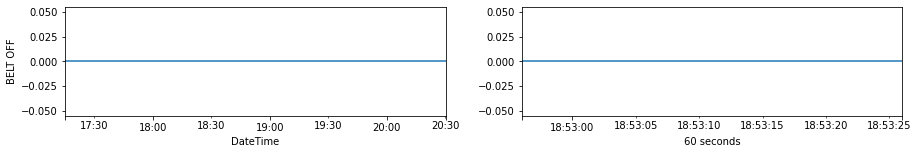

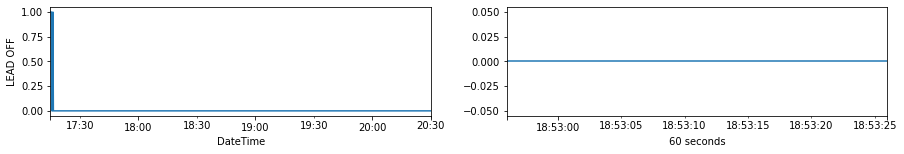

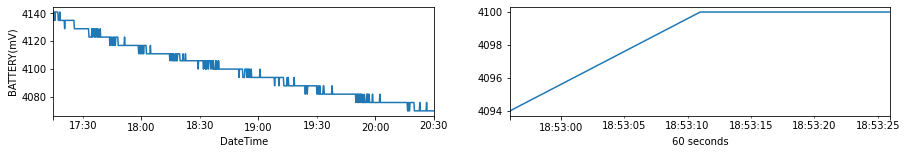

../SoloConcerting/SoloRecordings/SEM/Pilot_1/23020100.SEM


In [7]:
matched = qex.matched_files(dataLoc,path,seperater ) # outputs locations of csv 
for eq_file_loc in matched:
    print(eq_file_loc)
    if not eq_file_loc.lower().endswith('.sem'):
        V = pd.read_csv(eq_file_loc,skipinitialspace=True)
        print(V.columns)
        qex.test_plot_signals(V)

In [104]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-01 19:05:48.00+0100')# V['DateTime'].iloc[int(len(V)/2)]
t2 = t1+pd.to_timedelta(60,'s')
#t2 = pd.to_datetime('2023-02-01 20:45:00.00+0100')
[t1,t2]


[Timestamp('2023-02-01 19:05:48+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2023-02-01 19:06:48+0100', tz='pytz.FixedOffset(60)')]

Breathing
dACC
IBI
HR(BPM)


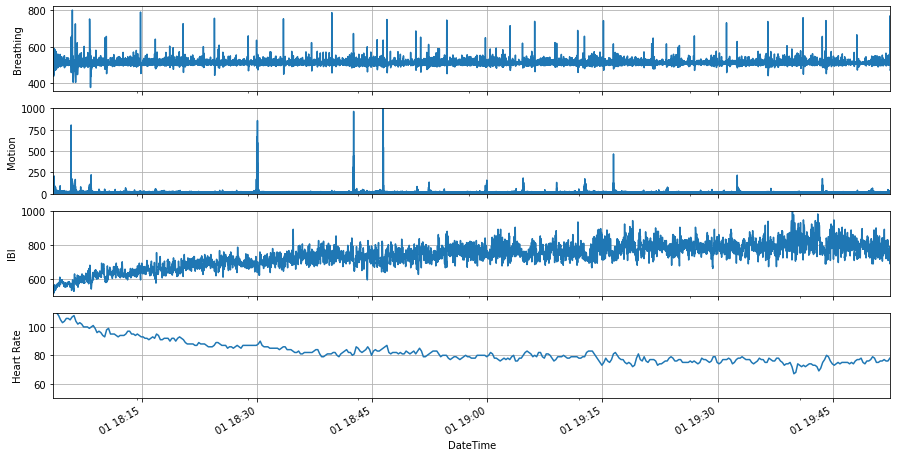

In [163]:
sig_set = ['HR','IBI','Breathing','dAcc']
fig, ax = plt.subplots(len(sig_set),1,figsize=[15,8],sharex = True)

for eq_file_loc in matched:
    if 'RESPACC' in eq_file_loc:
        V = qex.cut_by_time(eq_file_loc,t1,t2)
        
        print('Breathing')
        sig_tag = 'Breathing'
        sp = ax[0]
        V['Breathing'].plot(ax=sp)
        sp.set_ylabel(sig_tag)
        sp.set_xlabel('')
        sp.set_xlim([t1,t2])
        sp.set_xticklabels([])
        sp.grid()
        
        print('dACC')
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        sig_tag = 'Motion'
        sp = ax[1]
        sig_v.plot(ax=sp)
        sp.set_ylabel(sig_tag)
        sp.set_ylim([0,1000])
        sp.set_xlabel('')
        sp.set_xlim([t1,t2])
        sp.set_xticklabels([])
        sp.grid()
        
    if 'RR' in eq_file_loc:
        V = qex.cut_by_time(eq_file_loc,t1,t2)
        
        print('IBI')
        sig_tag = 'IBI'
        sp = ax[2]
        V['Interbeat Interval (MS)'].plot(ax=sp)
        sp.set_ylabel(sig_tag)
        sp.set_ylim([500,1000])
        sp.set_xlabel('')
        sp.set_xlim([t1,t2])
        sp.set_xticklabels([])
        sp.grid()
        
    if 'DATA' in eq_file_loc:
        V = qex.cut_by_time(eq_file_loc,t1,t2)  
        V.index = V.index+dt.timedelta(milliseconds=500) # to get the timeDate index in line
        print('HR(BPM)')
        sig_tag = 'Heart Rate'
        sp = ax[3]
        V['HR(BPM)'].plot(ax=sp)
        sp.set_ylabel(sig_tag)
        sp.set_ylim([50,110])
        sp.set_xlim([t1,t2])
        sp.grid()
#     V = pd.read_csv(eq_file_loc,skipinitialspace=True)
# #     print(V.iloc[:2,:])
#     qex.test_plot_signals_interval(V,t1,t2)

In [120]:
# ancher to recording time
synchTime = {'DateTime':pd.to_datetime('2023-02-01 18:05:48.80+0000'),'StimTime':11.240} # save me aligned
StimTime = (V.index - synchTime['DateTime']).total_seconds() + synchTime['StimTime']
StimTime                          

Float64Index([             1.843, 1.8819999999999997, 1.9209999999999994,
              1.9600000000000009,                2.0, 2.0389999999999997,
              2.0779999999999994,  2.117000000000001, 2.1560000000000006,
              2.1950000000000003,
              ...
                        5961.453,  5961.492000000001,  5961.531000000001,
               5961.570000000001,           5961.609,  5961.648000000001,
               5961.687000000001,  5961.726000000001,           5961.765,
               5961.804000000001],
             dtype='float64', name='DateTime', length=152576)

In [121]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-01 19:05:40.00+0100')# V['DateTime'].iloc[int(len(V)/2)]
#t2 = t1+pd.to_timedelta(60,'s')
t2 = pd.to_datetime('2023-02-01 20:45:00.00+0100')
[t1,t2]

[Timestamp('2023-02-01 19:05:40+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2023-02-01 20:45:00+0100', tz='pytz.FixedOffset(60)')]

In [122]:
# Export resp and dACC signal in stimulus time 
for eq_file_loc in matched:
    if 'RESPACC' in eq_file_loc:
        V = qex.cut_by_time(eq_file_loc,t1,t2)
        StimTime = (V.index - synchTime['DateTime']).total_seconds() + synchTime['StimTime']

        X = pd.DataFrame(index = StimTime, data = V['Breathing'].values)
        X.to_csv('./out_data/Test_solo_resp.csv')
        
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        
        X = pd.DataFrame(index = StimTime, data = sig_v.values)
        X.to_csv('./out_data/Test_solo_dAcc.csv')

# export specified interval of all matched CSV files

In [162]:
# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-01 19:03:30.00+0100')# V['DateTime'].iloc[int(len(V)/2)]
#t2 = t1+pd.to_timedelta(60,'s')
t2 = pd.to_datetime('2023-02-01 20:52:30.00+0100')
[t1,t2]
time_name = 'Theatre_Seated'

In [168]:
time_files_path = path + seperater + time_name
if not os.path.isdir(time_files_path):
    os.mkdir(time_files_path)


In [169]:
dataLoc = df_datafiles.loc[1,'FullLoc']

In [170]:
matched = qex.matched_files(dataLoc,path,seperater ) # outputs locations of csv 
for eq_file_loc in matched:
    if not eq_file_loc.lower().endswith('.sem'):
        fp = eq_file_loc.split(seperater)
        fn = fp[-1].split('.')
        fn_new = fn[0]+'-trimmed.csv'
        print(fn_new)
        V = qex.cut_by_time(eq_file_loc,t1,t2)
        print(V.columns)
        V.to_csv(time_files_path + seperater +fn_new)

../SoloConcerting/SoloRecordings/CSV/ECG-Pilot_1-3420755-23020100.csv
../SoloConcerting/SoloRecordings/CSV/RESPACC-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/DATA-Test1-3420415-23012007.CSV
../SoloConcerting/SoloRecordings/CSV/ECG-Test1-3420415-23012007.csv
../SoloConcerting/SoloRecordings/CSV/RESPACC-Test1-3420415-23012007.CSV
../SoloConcerting/SoloRecordings/CSV/RR-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/DATA-Pilot_1-3420755-23020100.CSV
../SoloConcerting/SoloRecordings/CSV/RR-Test1-3420415-23012007.CSV
ECG-Pilot_1-3420755-23020100-trimmed.csv
Index(['Lead 1', 'Lead 2'], dtype='object')
RESPACC-Pilot_1-3420755-23020100-trimmed.csv
Index(['Breathing', 'Vert Accelerometer', 'Lat Accelerometer',
       'Long Accelerometer'],
      dtype='object')
RR-Pilot_1-3420755-23020100-trimmed.csv
Index(['Interbeat Interval (MS)'], dtype='object')
DATA-Pilot_1-3420755-23020100-trimmed.csv
Index(['SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)', 'H

# Spectrogram of motion

In [123]:
X

,0
DateTime,
1.843,0.000000
1.882,5.656854
1.921,6.928203
1.960,8.000000
2.000,6.928203
...,...
5961.648,0.000000
5961.687,8.944272
5961.726,5.656854


In [124]:
from scipy import signal
from scipy.fft import fftshift


In [142]:
fs = 256
f, t, Sxx = signal.spectrogram(X.loc[2000:3000,0], fs)

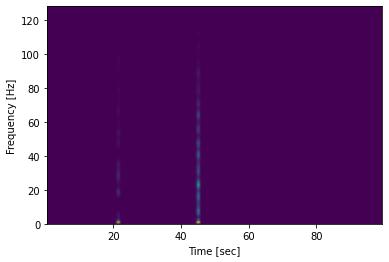

In [144]:
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

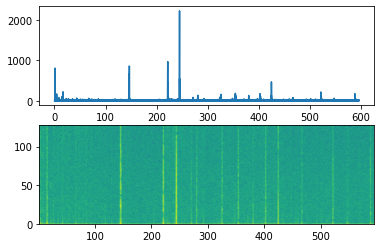

In [145]:
time = StimTime/10
x = X[0].values
NFFT = 1024 

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(time, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT,Fs=fs, noverlap=900)
plt.show()